In [1]:
import matplotlib as mpl
import matplotlib.pyplot as plt
%matplotlib inline
import numpy as np
import pandas as pd
pd.set_option('max_rows',1000)
import seaborn as sns
import os
from glob import iglob
from sklearn.metrics import auc
from scipy.stats import f_oneway
import MySQLdb
con = MySQLdb.connect(host='chgr2.accre.vanderbilt.edu', user='xiaoyi',
                        passwd='coiled-retention', db='ripleysK_results')

/Users/mikesivley/anaconda/lib/python2.7/site-packages/matplotlib/__init__.py:872: UserWarning: axes.color_cycle is deprecated and replaced with axes.prop_cycle; please use the latter.
  warnings.warn(self.msg_depr % (key, alt_key))


In [2]:
def get_cath_groups(con):
    sql = "SELECT pdbid,chain,CATH FROM pdbmap_supp.cath"
    df = pd.read_sql(sql,con)
    # Drop chains without CATH annotation
    df = df[df['CATH'] != '']
    df = df.drop_duplicates(['pdbid','chain','CATH'])
    # Dictionary mapping CATH IDs to CATH domain names
    with open('/Users/mikesivley/pdbmap/data/cath/cath-names-v4_1_0.txt','rb') as fin:
        cathnames = pd.read_csv(fin,sep='\t',skiprows=16,names=['CATH','acc','name'])
    cathnames = dict((r['CATH'],r['name'].lstrip(':')) for _,r in cathnames.iterrows())
    return df.groupby('CATH'),cathnames

In [3]:
# Calculate the AUC of a ROC curve
def roc_auc(fpr,tpr):
    rocauc = auc(fpr,tpr)
    return rocauc

In [4]:
# Calculate the AUC of a PR curve
def pr_auc(prec,rec):
    prec = np.maximum.accumulate(prec)
    prauc = auc(rec,prec)
    return prauc

In [5]:
# Calculate predictive performance within each CATH class
cath_groups,cath_names = get_cath_groups(con)
roc_auc_groups = {}

print "Evaluating..."
for cathid, group in cath_groups:
    pathrocauc,pathprauc = [],[]
    name = cath_names[cathid]
    print " %s"%name,
    # Identify (pdbid,chain)s in this CATH class
    structs = [[r["pdbid"].upper(),r["chain"].upper()] for _,r in group.iterrows()]
    
    for f in iglob("/Volumes/doux/pdbmap/results/multiROC_08302016/*clinvar-exac_roc*.txt.gz"):
        if os.path.basename(f).split('_')[0].split('-') in structs:
            df = pd.read_csv(f,sep='\t',header=None,names=["fpr","tpr"])
            rocauc = roc_auc(df["fpr"],df["tpr"])
            pathrocauc.append(rocauc)
    for f in iglob("/Volumes/doux/pdbmap/results/multiROC_08302016/*clinvar-exac_pr*.txt.gz"):
        if os.path.basename(f).split('_')[0].split('-') in structs:
            df = pd.read_csv(f,sep='\t',header=None,names=["prec","rec"])
            prauc = pr_auc(df["prec"],df["rec"])
            pathprauc.append(prauc)
            
    # Do not record if group contains fewer than 4 proteins from the PathProx analysis
    if len(pathrocauc)>3:
        roc_auc_groups[name] = {"pathroc":pathrocauc,"pathpr":pathprauc}

Evaluating...
 Orthogonal Bundle  Up-down Bundle  Alpha Horseshoe  Alpha solenoid  Alpha/alpha barrel  Ribbon  Aligned Prism  3-layer Sandwich  3 Propellor  4 Propellor  5 Propellor  6 Propellor  7 Propellor  8 Propellor  2 Solenoid  3 Solenoid  Beta Complex  Single Sheet  Roll  Beta Barrel  Clam  Sandwich  Distorted Sandwich  Trefoil  Orthogonal Prism  Roll  Ribosomal Protein L15; Chain: K; domain 2  Super Roll  Alpha-Beta Barrel  2-Layer Sandwich  3-Layer(aba) Sandwich  3-Layer(bba) Sandwich  3-Layer(bab) Sandwich  4-Layer Sandwich  Alpha-beta prism  Box  5-stranded Propeller  Alpha-Beta Horseshoe  Alpha-Beta Complex  Irregular


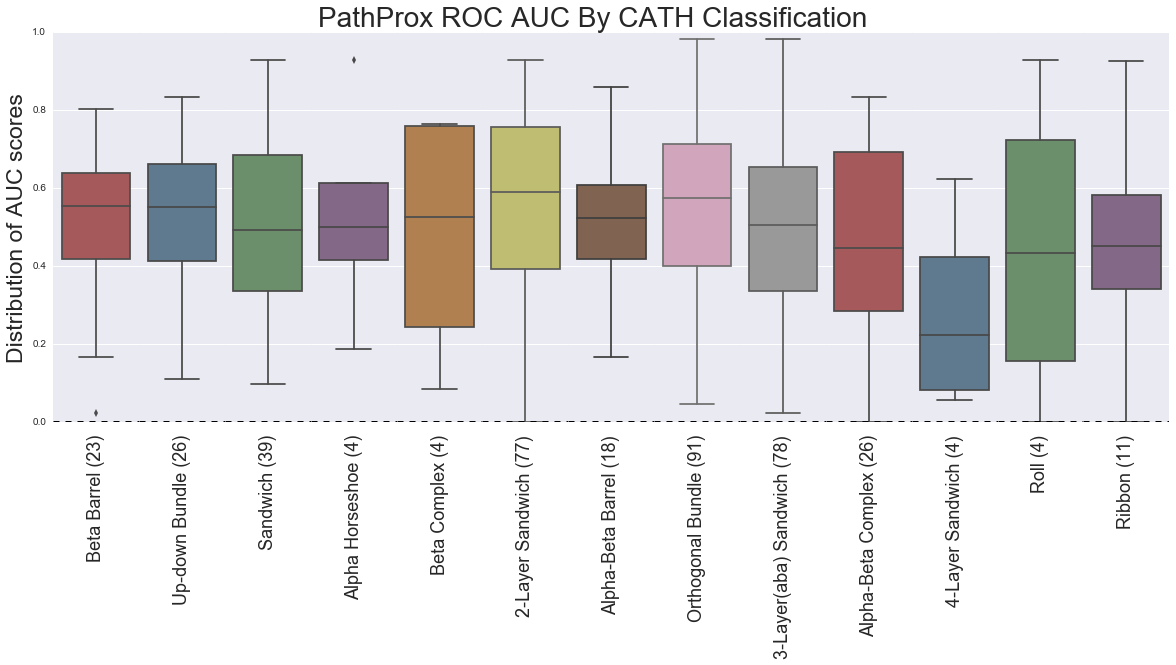

ANOVA: F=1.20, p=0.284


In [6]:
fig,ax = plt.subplots(1,len(roc_auc_groups.keys()),figsize=(20,7),sharey=True,facecolor='white')
plt.subplots_adjust(wspace=0, hspace=0)
pal = list(sns.color_palette("Set1", n_colors=len(roc_auc_groups.keys()), desat=.5))

for i,key in enumerate(roc_auc_groups):
    # Boxplot for each CATH class
    s = roc_auc_groups[key]["pathroc"]
    sns.boxplot(s,color=pal[i],ax=ax[i],orient='vertical')
    ax[i].set_xlabel("%s (%d)"%(key,len(s)),fontsize=18,rotation='vertical')
    ax[i].set_ylabel("")
    
plt.rcParams['xtick.labelsize'] = 20
ax[0].set_ylabel("Distribution of AUC scores",fontsize=23)
for x in ax:
    x.axhline(y=0,c='k',ls='dashed',lw=3)
plt.suptitle("PathProx ROC AUC By CATH Classification",fontsize=28,y=0.95)
plt.show()
print "ANOVA: F=%.2f, p=%.3g"%f_oneway(*[v['pathroc'] for v in roc_auc_groups.values()])

In [7]:
sigSeg = [["4DB1","A"],["2L4R","A"],["3GRO","A"],["2WPL","S"],["4FNW","A"],["3BIC","B"],["2GJX","G"],["4MLE","A"],["1WSV","A"],["3LUE","F"],["1G88","A"],["3RUK","C"],["2COY","A"],["2YOB","A"],["3DZY","D"],["2W86","A"],["2WWM","D"],["3U1K","D"],["3QFC","A"],["3N5N","X"],["3EQ1","B"],
["3EPZ","B"],["2UXW","A"],["3LXC","A"],["4BKT","I"],["1C9Y","A"],["3F5N","D"],["1RY7","B"],["2A1X","A"],["3PUF","A"],["2K27","A"],["3W1W","A"],["4KIT","C"],["3EE6","A"],["3EVS","B"],["1D5R","A"],["2FGI","A"],["4CDG","B"],["2DMB","A"],["1P49","A"],["3FBY","A"],
["2RD0","A"],["4AW6","E"],["3CXL","A"],["1NF1","A"],["4BGQ","A"],["3W82","B"],["2K60","A"],["3P0L","A"],["2M6I","A"],["3GHG","C"],["1XDV","B"],["2H5G","B"],["1YVL","A"],["2WTK","C"],["2Y1M","F"],["3II5","A"],["1K93","F"],["1BRP","A"],["4ELJ","A"],
["2OKN","A"],["3CON","A"],["3LBX","B"],["1FG9","C"],["4CH9","B"],["3LCO","A"],["1OWA","A"],["2R0O","B"],["2RMN","A"],["3N1P","B"],["2KKW","A"],["2FY5","A"],["3K71","D"],["2VR2","A"],["2E9W","D"],["1L5S","A"],["1NQ0","A"],["3BG3","A"],
["2SHP","B"],["4F91","B"],["1IIL","G"],["1NR1","C"],["4B7L","A"]]

In [8]:
# Calculate predictive performance within each CATH class
cath_groups,cath_names = get_cath_groups(con)
roc_auc_groups = {}

print "Evaluating..."
for cathid, group in cath_groups:
    pathrocauc,pathprauc = [],[]
    name = cath_names[cathid]
    print " %s"%name,
    # Identify (pdbid,chain)s in this CATH class
    structs = [[r["pdbid"].upper(),r["chain"].upper()] for _,r in group.iterrows()]
    
    for f in iglob("/Volumes/doux/pdbmap/results/multiROC_08302016/*clinvar-exac_roc*.txt.gz"):
        if os.path.basename(f).split('_')[0].split('-') in sigSeg:
            if os.path.basename(f).split('_')[0].split('-') in structs:
                df = pd.read_csv(f,sep='\t',header=None,names=["fpr","tpr"])
                rocauc = roc_auc(df["fpr"],df["tpr"])
                pathrocauc.append(rocauc)
    for f in iglob("/Volumes/doux/pdbmap/results/multiROC_08302016/*clinvar-exac_pr*.txt.gz"):
        if os.path.basename(f).split('_')[0].split('-') in sigSeg:
            if os.path.basename(f).split('_')[0].split('-') in structs:
                df = pd.read_csv(f,sep='\t',header=None,names=["prec","rec"])
                prauc = pr_auc(df["prec"],df["rec"])
                pathprauc.append(prauc)
            
    # Do not record if group contains fewer than 4 proteins from the PathProx analysis
    if len(pathrocauc)>3:
        roc_auc_groups[name] = {"pathroc":pathrocauc,"pathpr":pathprauc}

Evaluating...
 Orthogonal Bundle  Up-down Bundle  Alpha Horseshoe  Alpha solenoid  Alpha/alpha barrel  Ribbon  Aligned Prism  3-layer Sandwich  3 Propellor  4 Propellor  5 Propellor  6 Propellor  7 Propellor  8 Propellor  2 Solenoid  3 Solenoid  Beta Complex  Single Sheet  Roll  Beta Barrel  Clam  Sandwich  Distorted Sandwich  Trefoil  Orthogonal Prism  Roll  Ribosomal Protein L15; Chain: K; domain 2  Super Roll  Alpha-Beta Barrel  2-Layer Sandwich  3-Layer(aba) Sandwich  3-Layer(bba) Sandwich  3-Layer(bab) Sandwich  4-Layer Sandwich  Alpha-beta prism  Box  5-stranded Propeller  Alpha-Beta Horseshoe  Alpha-Beta Complex  Irregular


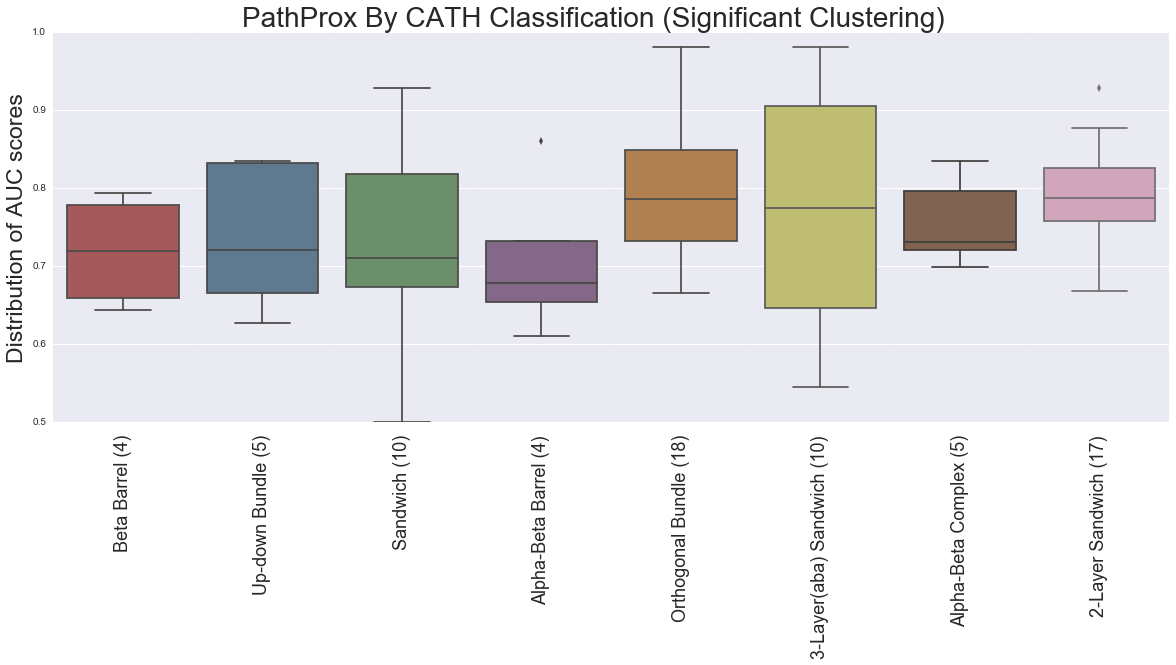

ANOVA: F=0.85, p=0.549


In [9]:
fig,ax = plt.subplots(1,len(roc_auc_groups.keys()),figsize=(20,7),sharey=True,facecolor='white')
plt.subplots_adjust(wspace=0, hspace=0)
pal = list(sns.color_palette("Set1", n_colors=len(roc_auc_groups.keys()), desat=.5))

for i,key in enumerate(roc_auc_groups):
    # Boxplot for each CATH class
    s = roc_auc_groups[key]["pathroc"]
    sns.boxplot(s,color=pal[i],ax=ax[i],orient='vertical')
    ax[i].set_xlabel("%s (%d)"%(key,len(s)),fontsize=18,rotation='vertical')
    ax[i].set_ylabel("")
    
plt.rcParams['xtick.labelsize'] = 20
ax[0].set_ylabel("Distribution of AUC scores",fontsize=23)
plt.suptitle("PathProx By CATH Classification (Significant Clustering)",fontsize=28,y=0.95)
plt.show()
print "ANOVA: F=%.2f, p=%.3g"%f_oneway(*[v['pathroc'] for v in roc_auc_groups.values()])